In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import enlighten
from collections import defaultdict as ddict

#!source activate my-rdkit-env && python
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.rdmolops import SanitizeFlags

from IPython.core.display import HTML

#ML requirements sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.cluster import KMeans

RDLogger.logger().setLevel(RDLogger.CRITICAL)

# RDLogger.logger().setLevel(RDLogger.WARNING)

not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']
#molecule descriptor calculator
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])


## Defining functions to use

In [2]:
#write some stuff
def stats(A,B):
    assert len(A) == len(B)
    R2 = np.round(r2_score(A, B))
    MAE = np.round(mean_absolute_error(A,B))
    return R2, MAE

def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))

def remove_aromatisation(mol):
    for atom in mol.GetAromaticAtoms():
        #bugfixing
        # print(atom.getIsAromatic())
        # print(atom.getSymbol())
        atom.SetIsAromatic(False)

def get_frag_env(mol, atom_x, radius):
    bond_x = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_x)
    if len(bond_x) == 0:
        return None
    atom_x_set = set()
    for b_x in bond_x:
        b = mol.GetBondWithIdx(b_x)
        atom_x_set.add(b.GetBeginAtomIdx())
        atom_x_set.add(b.GetEndAtomIdx())
    return Chem.MolFromSmiles(Chem.MolFragmentToSmiles(mol, atom_x_set, bond_x), sanitize=False)

def get_frag(mol, atom_x, radius):
    frag = None
    r = radius

    while frag is None and r > 0:
        frag = get_frag_env(mol, atom_x, r)
        r -= 1
    if frag is None:
        raise ValueError("No fragment extracted")

    # error/issue catching
    r = radius + 1
    #sanitised to calculated descriptors
    not_sanitised = Chem.SanitizeMol(frag, catchErrors=True)

    while not_sanitised:
        if not_sanitised == SanitizeFlags.SANITIZE_KEKULIZE:
            remove_aromatisation(frag)
        elif not_sanitised == SanitizeFlags.SANITIZE_PROPERTIES:
            frag = get_frag_env(mol, atom_x, r)
            r += 1
        not_sanitised = Chem.SanitizeMol(frag, catchErrors=True)
    return frag


In [3]:
#assay identification number
#AID as written in PubChem database

#hERG ion channel modulator assay
assay = 1511

In [4]:
#backup excel method
excelfile = "AID_1511_datatable_all.csv"

In [5]:
#compile Assay molecules into SDF
from pubapi import get_data_AID_csv as assayinfo

#get assay info

try:
    assay_info = assayinfo.get_data_AID_csv(assay)

except:
    print("Error in download")
#backup method

# with open(excelfile, 'r') as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')
#     assay_info = []
#     headers = ['PUBCHEM_ASSAY_ID']
#     for id, row in enumerate(reader):
#         if id == 0:
#             headers.append(row[1:4])
#             assay_info.append(headers)
#         try: 
#             int(row[0]) == 1
#         except ValueError:
#             #line is descriptive
#             continue
#         if row[2] == '':
#             #CID is missing/not present
#             row[2] = 0
#             #continue

#         line = [assay, int(row[1]), int(row[2]), row[3]]
#         assay_info.append(line)



Number of substances tested in assay AID 1511 are: 305679
Assay size is over 10,000
This exceeds the max number of lines that can be requested at once.
Requesting info of assay 1511


Done.
Assay 1511 has been successfully downloaded.


In [6]:
all_df = pd.DataFrame(assay_info[1:],columns=assay_info[0])

# all_df = pd.DataFrame(assay_info[1:],columns=assay_info[0])
#get list of CIDs from the assay
print(all_df.head(10))

CIDs = all_df['PUBCHEM_CID'].to_list()

# from pubapi import get_SDF_CIDs as SDFs

# SDFs.compile_SDFs(CIDs)


   PUBCHEM_ASSAY_ID  PUBCHEM_SID  PUBCHEM_CID PUBCHEM_ACTIVITY_OUTCOME
0              1511     56314828         1988                 Inactive
1              1511     56321651       425322                 Inactive
2              1511     56322145     24981957                 Inactive
3              1511     51090143      7384392                 Inactive
4              1511     51090795      7423030                 Inactive
5              1511     51090141      7526417                 Inactive
6              1511     51090145     16268999                 Inactive
7              1511     51090492     18573514                 Inactive
8              1511     51090139     18577942                 Inactive
9              1511     51089977     18582778                 Inactive


In [7]:
all_df["PUBCHEM_CANONICAL_SMILES"] = np.nan

In [8]:
#add the SMILES from the SQL database to each of the CIDs in the 

#do it with internal mariadb
#uncomment
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

from search_laurus import query_db

query = f'SELECT * FROM aggregator.pubchem_compound WHERE ' 

pbar = enlighten.Counter(total=(len(CIDs)), desc='Querying Laurus...', unit='ticks')
for i in CIDs:
    
    #Search for CIDs
    CID_search = query + f'pubchem_id = {i};' 
    info = query_db(CID_search)

    #parse
    for j in info:
        # pubchem = j[0]
        # compound = j[1]
        smiles = j[5]
        all_df.loc[all_df["PUBCHEM_CID"] == i, 'PUBCHEM_CANONICAL_SMILES'] = smiles

    pbar.update()



CC(=O)OC1=CC=CC=C1C(=O)O


In [9]:
#now convert the SMILES strings to MOL objects
PandasTools.AddMoleculeColumnToFrame(all_df, 'PUBCHEM_CANONICAL_SMILES', 'MOL', includeFingerprints=True)


[12:16:12] WARNING: not removing hydrogen atom without neighbors
[12:16:13] WARNING: not removing hydrogen atom without neighbors


In [2]:
show(all_df.head(4))

NameError: name 'show' is not defined

In [11]:
#write molecules to SDF
PandasTools.WriteSDF(all_df, f'{assay}_compounds.sdf', molColName='MOL', properties=all_df.columns)

In [12]:
#TODO
#get fingerprints and split into fragments.
min_radius = 3
max_radius = 5

radii = list(range(min_radius, max_radius))

In [31]:
# test_df = all_df[129607:129608]

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,MOL
129607,1511,24821302,54689225,Inactive,CC1=[N+](C2=CC=C3C(=NON3O)C2=C1C(=O)C)[O-],

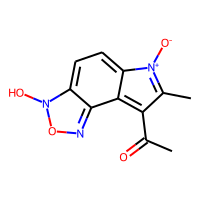

In [32]:
# show(test_df.head(4))

In [33]:
# frags = ddict(list)

# #check to see how long this may actually take
# frag_prog = enlighten.Counter(total=(len(test_df)), desc='Creating Fragments...', unit='ticks')

# count = 0
# for index, row in test_df.iterrows():
#     if count > 130000:
#         break
#     atom_x = 0
#     mol = row.MOL
#     for i in radii:
#         try:
#             frags[i].append(get_frag(mol, atom_x, i))
#         except:
#             print(index)
            
#     count += 1
#     frag_prog.update()


# for i in radii:
#     test_df[f'FRAG_R{i}'] = frags[i]

# show(all_df.head(10))


129607
129607


[13:07:34] non-ring atom 1 marked aromatic
[13:07:34] Can't kekulize mol.  Unkekulized atoms: 1 2 6 8 10


In [37]:
frags = ddict(list)

#check to see how long this may actually take
frag_prog = enlighten.Counter(total=(len(all_df)), desc='Creating Fragments...', unit='ticks')

count = 0
for index, row in all_df.iterrows():
    if count > 130000:
        break
    atom_x = 0
    mol = row.MOL
    for i in radii:
        try:
            frags[i].append(get_frag(mol, atom_x, i))
        except:
            print(index)
            
    count += 1
    frag_prog.update()


for i in radii:
    all_df[f'FRAG_R{i}'] = frags[i]

# show(all_df.head(10))




[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 1 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 7 marked ar

[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] Can't kekulize mol.  Unkekulized atoms: 2 3 5
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 4 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 6 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 0 marked aromatic
[13:26:37] non-ring atom 7 marked aromatic
[13:26:37] non-ring atom 0 marked aromat

1997


[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 5 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 6 marked aromatic
[13:26:39] non-ring atom 0 marked aromatic
[13:26:39] non-ring atom 2 marked aromatic
[13:26:39] 

: 

: 

In [104]:
#Calculate descriptors for fragments

keys = radii + [max_radius]
descr = ddict(list)


for index, row in all_df.iterrows():
    for i in keys:
        mol = row.MOL if i == max_radius else row[f'FRAG_R{i}']
        
        descr[i].append(desc_calc.CalcDescriptors(mol))




In [106]:
#create fingerprints for all molecules/fragments

morgan0 = ddict(list)
morgan1 = ddict(list)
morgan2 = ddict(list)
morgan3 = ddict(list)
topol = ddict(list)
atpair = ddict(list)


for index, row in all_df.iterrows():
    for i in keys:
        mol = row.MOL if i == max_radius else row[f'FRAG_R{i}']
        morgan0[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=0))
        morgan1[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=1))
        morgan2[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=2))
        morgan3[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3))
        topol[i].append(Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))
        atpair[i].append(Chem.GetHashedAtomPairFingerprintAsBitVect(mol))


,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,MOL,FRAG_R3,FRAG_R4
0,1511,24831648,4077805,1,CC1=CC=C(O1)C2=CSC3=C2C(=O)N(C(=S)N3)CC=C,,,
1,1511,24836603,5077197,0,CC1=C(C(=O)N(N1C)C2=CC=CC=C2)NC(=O)C(C)OC(=O)C...,,,
2,1511,24836178,2346638,0,C1CCN(CC1)S(=O)(=O)C2=C(C=CC(=C2)C(=O)OCC(=O)N...,,,
3,1511,24835895,2434592,0,C1CCCN(CC1)C(=O)COC(=O)C2=CC(=C(C=C2)Cl)S(=O)(...,,,

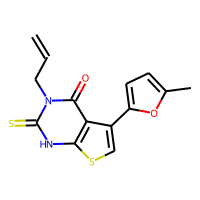
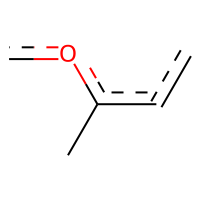
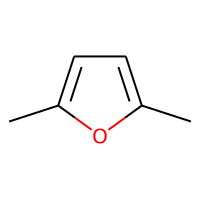
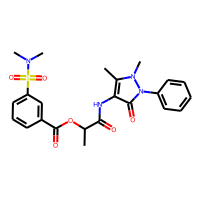
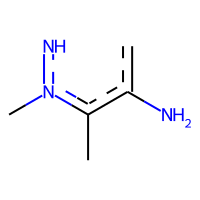
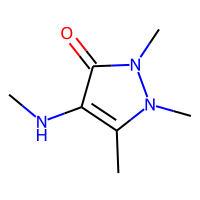
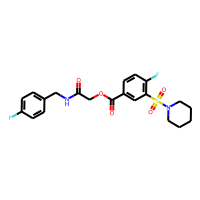
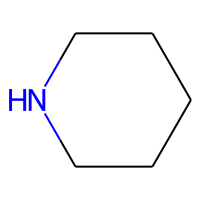
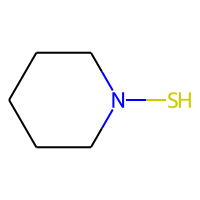
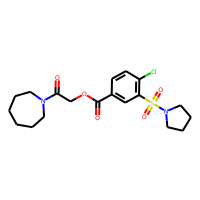
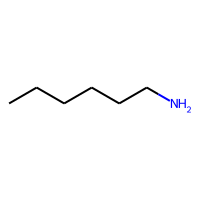
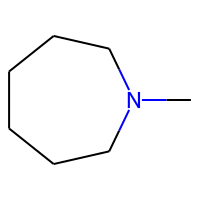

In [107]:
#replace activity with 1 if active and 0 if inactive
all_df["PUBCHEM_ACTIVITY_OUTCOME"].replace("Inactive", 0, inplace=True)
all_df["PUBCHEM_ACTIVITY_OUTCOME"].replace("Active", 1, inplace=True)

show(all_df.head(4))

In [108]:
seed = 20
folds = 5
jobs = 12

y_data = all_df["PUBCHEM_ACTIVITY_OUTCOME"]
x_data = dict(Descriptors=descr, Morgan0=morgan0, Morgan1=morgan1, Morgan2=morgan2, 
                  Morgan3=morgan3, Topological=topol, AtomPair=atpair)

kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
spl = list(kf.split(descr[max_radius], y_data))

In [109]:
trees = 1000

In [ ]:
all_scores = {}
for dsetname, dset in x_data.items():
    # print(dset)
    print(f'Random Forest - {dsetname}:')
    scores = {}
    for i in dset:
        # print(i)
        # print(dset[i])
        est = RandomForestClassifier(n_estimators=trees, random_state=seed, n_jobs=jobs)
        score = cross_val_score(est, dset[i], y_data, cv=spl, error_score='raise')
        print(score)
        scores[i] = dict(r2=np.mean(score), r2_std=np.std(score))
        print(f'\tRadius {i if i != max_radius else "M"} - R²: '
              f'{np.round(scores[i]["r2"], 3)} ± {np.round(scores[i]["r2_std"], 3)}')
    all_scores[dsetname] = scores

In [ ]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(descr, y_data, test_size=test_size, random_state=seed)

